### 필요한 모듈 포함하기

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

### 데이터 전처리
데이터 모델이 데이터를 처리하기 쉬운 형태로 변환하기 위한 목적<br>
데이터셋 로드 전 데이터셋 전처리 방식 정의<br>
- Normalize는 `QMNIST` 데이터셋의 경우 흑백 이미지 데이터기 때문에 각 인자 배열의 첫 번째(한 개의 채널) 값만 전달

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))
])

### 데이터셋 준비
학습시키고자 하는 데이터셋 로드 및 전처리 적용<br>
학습이 목적인 `trainset`과 모델 정확도 테스트를 위한 `testset`으로 분류<br>
또한 CNN모델에 입력할 수 있도록 각 `trainset`과 `testset`을 `DataLoader`를 사용하여 변환
- QMNIST 데이터셋을 가져오기 위해 `datasets.QMNIST` 사용

데이터셋 가져오기<br>
- download : 데이터셋 미 존재 시 다운로드 여부
> 데이터셋 파일이 로컬 폴더에 있는 경우 `download=False` 로 설정<br>
- train : 학습 데이터 여부
> 학습 데이터를 가져오는 경우 `train=True` 테스트일 경우 `train=False`<br>
- transform : 데이터셋의 데이터들에 대해 전처리 여부
> 각 데이터들에 전처리를 진행할 경우 `transform=transform` 적용

데이터 로더로 변환
- batch_size : 한번에 처리할 데이터 수
> 가중치 업데이트 속도가 느려짐 / 정확도가 올라 갈 수 있으나 지역최적점에 갇힐 수 있음
- shuffle : 학습 데이터 순서 의존 여부
> `shuffle=True` 인 경우 데이터 학습 순서에 의존하지 않음

In [ ]:
train_data = datasets.QMNIST(root='./data', train=True, download=False, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

test_data = datasets.QMNIST(root='./data', train=False, download=False, transform=transform)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

### CNN 모델 객체로 구현
Convolution 연산, Max Pool 기술을 사용하여 특징점을 추출하고,<br>
추출한 특징점을 가지고 이미지를 분류하는 기술<br>
- 각 기술들을 조합하여 선택한 데이터셋에 적합한 모델 설계

객체 함수
`__init__` : 객체 선언 시 실행<br>
> 각 컨볼루션 레이어, 맥스 풀링 레이어의 채널 및 커널 사이즈 정의와<br>
> 선형 레이어의 입력 및 출력 벡터의 차원 수를 정의<br>
`forward` : model 객체를 데이터와 함께 호출 시 호출됨 `ex) model(data)`<br>
> 각 레이어를 순차적으로 실행하여 예측값을 반환

내부적 호출 함수
`nn.Conv2d` : 컨볼루션 레이어 정의<br>
> 특징 맵 생성<br>
> (입력 채널 수, 출력 채널 수, 필터 크기)<br>
`nn.MaxPool2d` : 풀링 레이어 정의<br>
> 특징 맵 크기를 줄임<br>
> (필터 크기, 스트라이드 값)<br>
`nn.Linear` : 선형 레이어 정의<br>
> 선형 변환 수행<br>
> (입력 크기, 출력 크기)<br>
`F.relu` : 비선형 변환<br>
> 0보단 작거나 같은 경우 0을 출력<br>
> 그외 양의 정수 값은 그대로 출력<br>
> (데이터)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

model = CNN()

### 모델 학습
데이터셋의 학습 데이터를 통해 모델을 학습시키는 함수

1. 모델 학습모드 전환
2. 각 학습 데이터를 배치 단위로 순회
3. 이전 배치의 그래디언트 초기화
4. model에 테스트 데이터를 입력해 예측값 얻기
5. 예측값과 레이블값을 비교해 손실값 얻기
6. 역전파를 수행해, 그래디언트 계산
7. 계산된 그래디언트를 사용해 최적의 알고리즘을 수행 후 모델 업데이트
8. 결과 출력

In [ ]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, data in enumerate(train_loader):
        data, target = data
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print(f'Train Epoch: {epoch+1} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

### 모델 테스트
학습된 모델의 성능을 평가하는 함수

1. 모델 평가모드 전환
2. 그래디언트 계산 비활성화
3. 각 학습 데이터를 배치 단위로 순회
4. model에 테스트 데이터를 입력해 예측값 얻기
5. 예측값과 레이블값을 비교해 손실값 얻기
6. 예측결과 추출
7. 정확도 계산
8. 평균 손실과 평균 정확도 계산
9. 결과 출력


평가방법
1. model에 데이터를 입력해 `예측값` 얻기
2. `예측값`과 `실제 레이블` 간 `손실 계산`
> 손실이 작을수록 모델의 성능이 좋음
3. 예측값과 실제 레이블 `일치 비율` 계산

In [ ]:
def test(model, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data in test_loader:
            data, target = data
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, '
        f'Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n')

### 모델 성능 개선 방안
1. 데이터 증강
> 원본 데이터를 회전, 뒤집기, 확대/축소, 밝기/색상 변경 과정을 통해 데이터 양의 증가
2. 배치 정규화
> 각 층의 입력 데이터 평균을 0, 분산이 1이 되도록 정규화
> > 내부 공변량 변화(데이터 특성 변형)를 해결하기 위한 방법<br>
> > 각 층의 출력 시 데이터를 정규화하여 각 층의 역할에 집중시켜 학습속도 향상
3. 학습률 스케줄링
> 초기에 큰 학습률을 사용하여 빠르게 학습 후 점차 학습률을 감소시켜 최적화<br>
> 즉, 초기에 모델을 단순하고 빠르게 학습하고, 점차 모델을 깊이있게 학습<br>
> > 경사하강법에서 가중치를 업데이트하는 데 있어서 학습률이 높을 경우 정확한 답을 찾기 어렵고,<br>
> > 학습률이 낮을 경우 지역 최소값에 갇히거나, 학습 속도가 매우 낮아짐
4. 더 깊은 모델 사용
> CNN 내부 컨볼루션, 풀링 레이어를 추가하여 모델 구조를 복잡하게 수정<br>
> 추가된 레이어를 통해 복잡한 패턴을 학습할 수 있으나, 과적합 문제가 발생할 수 있음
> > `드롭아웃`과 같은 정규화 기법을 통해 과적합을 방지할 수 있음
5. Early Stopping
> 검증 오차가 더 이상 감소하지 않을 때 학습을 중단<br>
> 해당 시점의 모델을 선택하여 학습 시간 단축 효과

### 모델 저장
학습된 모델을 저장하는 함수
- 아래 코드는 `model{학습 번호}.pt` 파일명으로 저장

In [ ]:
def save_model(model, epoch):
    torch.save(model.state_dict(), 'model-' + str(epoch) + '.pt')

### 모델 학습을 위한 준비 
1. 예측값과 실제값 사이 손실을 계산하는 함수 준비<br>
2. 모델 학습 과정에서 손실 함수 최소화를 위한 최적화 알고리즘 준비<br>
3. 훈련 횟수 준비

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
epochs = 5

### 모델 훈련 및 테스트
훈련 횟수만큼 `훈련 > 테스트 > 모델 저장` 과정 반복<br>
> /data 내부에 QMNIST 데이터 파일 확인 (data 내부의 모든 QMNIST 데이터를 학습/테스트)

In [ ]:
for epoch in range(epochs):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader, epoch)
    save_model(model, epoch)

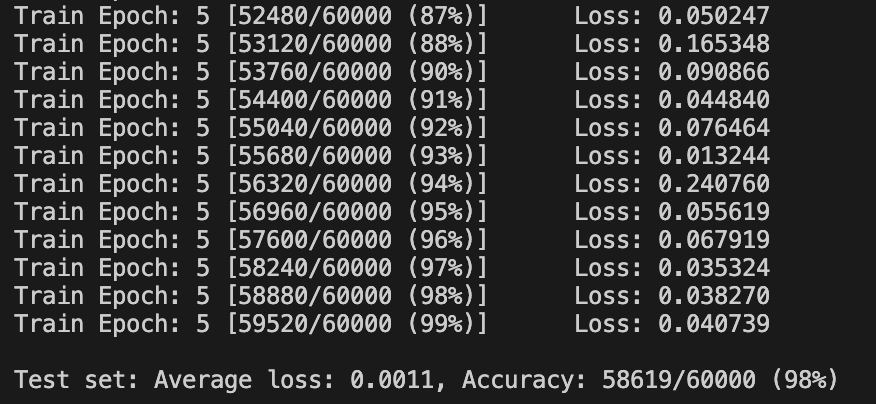